# Network Analytics Project

In [76]:
group_members=['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']
print('Project: CIS6930 Network Analytics & Machine Learning')
print('Group Members:', group_members)

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from datetime import datetime
import pickle

print('\nLibrary Versions')
print('### Python version: ' + __import__('sys').version)
print('### Pandas Version: ' + pd.__version__)
print('### MatPlotLib version:' + matplotlib.__version__)
print('------------')

Project: CIS6930 Network Analytics & Machine Learning
Group Members: ['Pankaj Chand', 'Keith Levengood', 'Nicholas Kroeger', 'Varun Puri']

Library Versions
### Python version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
### Pandas Version: 1.2.2
### MatPlotLib version:3.3.4
------------


# Load in data

In [3]:
import itertools

# Helper function to get the prefix of each APNAME 
def convertAPNameToPrefix(df):
    prefixes = []
    for i in range(len(df)):
        tempPrefix = ["".join(x) for _, x in itertools.groupby(df.iloc[i], key=str.isdigit)][0]
        prefixes.append(tempPrefix)
    return prefixes

In [4]:
loadPreprocessedData = True

In [5]:
if loadPreprocessedData == False:
    #load in csv, append APNAME to end of dataframe, save it out as .pkl
    data = pd.read_csv('DHCP_April_2012_ANON_MAC_devType.csv')
    print("loaded first dataframe")
    
    print("Appending prefix name to table... will take a few minutes")
    
    prefixes_col   = convertAPNameToPrefix(data['APNAME'])
    data['prefix'] = prefixes_col
    
    print("Saving out new dataframe to .pkl file")
    data.to_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")
else:
    #load in preprecossed data
    data = pd.read_pickle("./DHCP_April_2012_ANON_MAC_devType_wAPNAME.pkl")

# Look at the data

In [28]:
data.head(), data.shape

(           userIP  userMAC                APNAME              APMAC  \
 0   10.131.172.58    26257  fli113-win-lap3502-1  44:e4:d9:00:ed:e0   
 1        10.0.1.3    22699  hrb112-win-lap1231-1  00:1a:a2:09:93:90   
 2  10.132.190.205    30264  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 3  10.130.146.252    72815  soc1402-temp-lap3502  58:35:d9:d5:cd:c0   
 4   10.130.248.68    69249               unknown  00:00:00:00:00:00   
 
     startTime     endTime deviceType   prefix  
 0  1333238682  1333238682          f      fli  
 1  1333238682  1333238687    unknown      hrb  
 2  1333238685  1333238687          f      soc  
 3  1333238688  1333238688          f      soc  
 4  1333238690  1333238690          f  unknown  ,
 (22821939, 8))

2012-04-01 00:04:41
2012-05-01 00:05:20


<AxesSubplot:>

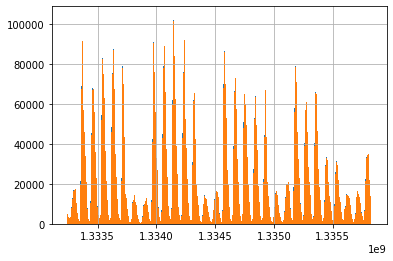

In [6]:
print(pd.to_datetime(data['startTime'].min(), unit='s'))
print(pd.to_datetime(data['endTime'].max(), unit='s'))
data['startTime'].hist(bins=1000)
data['endTime'].hist(bins=1000)

# Load in prefix and building information

In [7]:
prefix_lat_lon = pd.read_csv('prefix_lat_lon_name_category.csv')
legalPrefixes = prefix_lat_lon.prefix

In [24]:
legalPrefixes.head()

0     aaf
1     adv
2     aer
3    aerv
4     alf
Name: prefix, dtype: object

# Clean the data

In [227]:
#prefixes found from our preprocessing function
prefixesFound = np.unique(data.prefix)

In [228]:
#prefixes in the base table that don't match in the prefix table 
#TODO: more preprocessing to keep some of these?
unknownPrefixes = list(np.setdiff1d(prefixesFound, np.asarray(legalPrefixes)))

In [229]:
unknownPrefixes

['AP',
 'APc',
 'APe',
 'APf',
 'apopka-win-lap',
 'b',
 'broEastOIR-win-lap',
 'broOIR-EB',
 'bwcbookstore-win-lap',
 'carATTIC-win-lap',
 'carATTIC-wout-lap',
 'cba-ftlauderdale-win-lap',
 'crecxxxrxx-win-lap',
 'ctx',
 'dairy-win-lap',
 'dauxxx-win-lap',
 'dinefreshfood-win-lap',
 'escv',
 'fsf-win-lap',
 'hotidf-win-lap',
 'irrec',
 'mowv',
 'ohl',
 'osbs-win-lap',
 'osbs-xxx-win-lap',
 'pep',
 'presAttic-wout-lap',
 'presStairs-win-lap',
 'reiOrangeBrew-win-lap',
 'rl',
 'rubygillhs-win-lap',
 'soc-temp-lap',
 'stzWlkwy-wout-lap',
 'treeo-win-lap',
 'uic-win-lap',
 'unknown',
 'weiclocktower-wout-lap',
 'wrt']

In [35]:
#keep only valid prefixes (based on the prefix_lat_lon_name_category.csv table)
#removes about 400k rows?
dataLegalPrefixes = data[~data['prefix'].isin(unknownPrefixes)]
dataLegalPrefixes.shape

(18258287, 8)

## Get information about each user (useful for prediction later)

In [113]:
location_info = prefix_lat_lon[['prefix','name','category']]
location_info.head()

,prefix,name,category
0,aaf,Academic Advising Center,admin
1,adv,Martin H. Levin Advocacy Center,academic
2,aer,Mec. Aerospace Engineering,academic
3,aerv,Mec. Aerospace Engineering,academic
4,alf,Alfred A. Ring Tennis Pavilion,sports


In [110]:
if loadPreprocessedData == False:
    #can take ~30min
    numUniqueUsers = max(data.userMAC)
    print("Number of unique users:", numUniqueUsers)
    
    PeopleForPred = []
    #loop over all users
    for i in range(numUniqueUsers):
        if i % 200 == 0: #print for info since this takes a while
            print("Percent Done:", round(i/numUniqueUsers*100,2), "Num people found so far:", len(PeopleForPred))
        userHistory = dataLegalPrefixes[dataLegalPrefixes.userMAC == i]

        #remove irrelevant information (save space)
        userHistory = userHistory[['startTime', 'endTime', 'userMAC', 'prefix']]
        
        #join the base table prefix with location info table (get building name for each prefix)
        userHistory = userHistory.set_index('prefix').join(location_info.set_index('prefix'), on='prefix', how='inner')

        # append info to list for persion userMAC i
        PeopleForPred.append(userHistory)

    #save data
    with open('PeopleForPred_all.data', 'wb') as file:
        pickle.dump(PeopleForPred, file)
else:
    with open('PeopleForPred_all.data', 'rb') as file:
        PeopleForPred = pickle.load(file)

In [112]:
print("Num people:", len(PeopleForPred), "\nFirst user's info:\n", PeopleForPred[1])

Num people: 86344 
First user's info:
          startTime     endTime  userMAC         name  category
prefix                                                        
nrn     1334926411  1334926805        1  Norman Hall  academic


In [ ]:
NumAP_Threshold = 100 #min number of thresholds a user has to visit 

# Markov Chain

In [ ]:
#predict for each user, where will they go next?
#predict across all users, where will an arbitrary person go next?

#Question: constrain the prediction of each user to be based only on where they've been before?
#Question: if not, assume that being in each building is equally likely?

In [172]:
def MakeTransitionMatrix(history):
#      Input: DataArray - array of length N of integers that belong to 1 of C classes
#      Output: TransMat - is a right stochastic matrix (each row sums to 1)
#                         Each entry of TransMat(i,j) represents the probability
#                         of going from label i to label j
    NumTimeSteps  = len(history)
    NumComponents = np.max(history)
    
    #Pre-allocate transition matrix
    TransMat = np.zeros((NumComponents+1, NumComponents+1)) #+1 because 0-indexed

    for i in range(NumTimeSteps-1):
        Current = history[i]
        Next    = history[i+1]
        TransMat[Current, Next] = TransMat[Current, Next] + 1
        
    #Normalize rows
    TransMat = TransMat/np.sum(TransMat,1)[:,None] #broadcast vector for normalization by rows
    return TransMat

In [215]:
def FindNextState(TransMat, state, loc_dict, plotNextStateProb=False):
    #assume state is 0-indexed
    rand = np.random.random()
    
    #Make cdf of transitioning out of a given state
    cdf = np.cumsum(TransMat[state])    

    #find first state above random number on cdf
    nextState = np.where(cdf > rand)[0][0]
    
    if plotNextStateProb: #plot cdf and probability of transitioning
        StateSize = len(TransMat)
        plt.figure(dpi=100)
        plt.plot(np.insert(cdf, 0, 0))
        plt.title("Cumulative Distribution function" + " - Chose state " + str(nextState) + ' ' + loc_dict[nextState])
        plt.axhline(rand, c='red')
        for i in range(StateSize):
            plt.axvline(i, c='k')
        plt.show()
    
    return nextState

In [ ]:
def PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=False):
    nextStates  = []
    nextBldgs   = []
    currState   = MostRecentState
    for i in range(NumFutureSteps):
        nextState = FindNextState(TransMat, currState, bldg_dict, PlotCDF)
        print("\nNext state", bldg_dict[nextState])
        nextStates.append(nextState)
        nextBldgs.append(bldg_dict[nextState])
        currState = nextState

    print("Next states array:", nextStates)
    print("Next buildings array:", nextBldgs)
    return nextStates, nextBldgs

TransMat:
 [[0.5        0.5        0.         0.        ]
 [0.2        0.2        0.6        0.        ]
 [0.16666667 0.16666667 0.16666667 0.5       ]
 [0.         0.33333333 0.66666667 0.        ]]


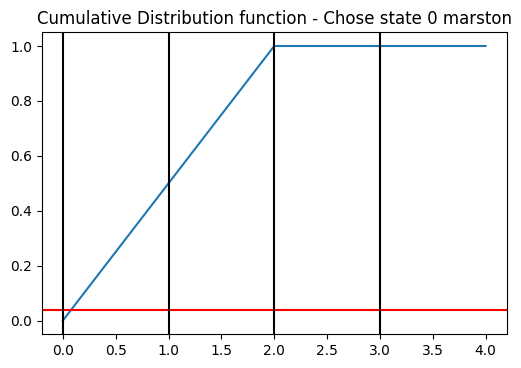


Next state marston


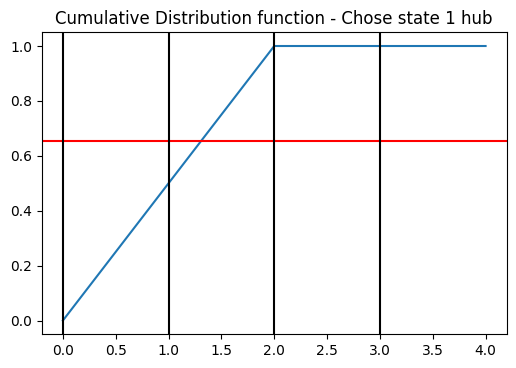


Next state hub


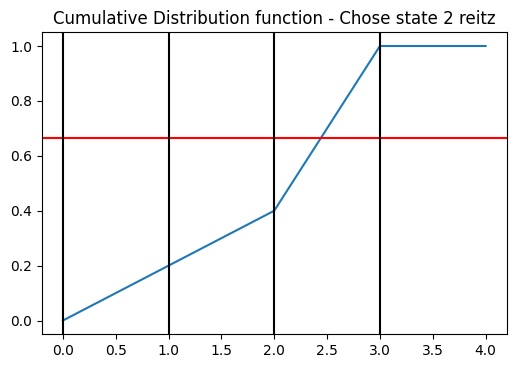


Next state reitz


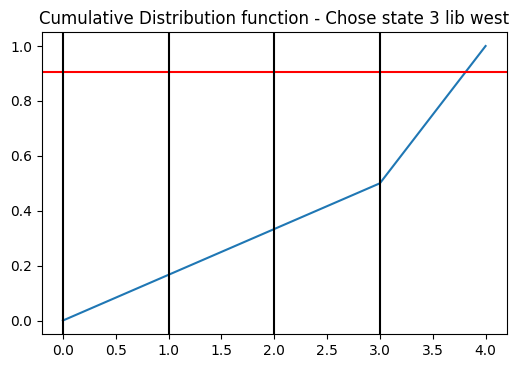


Next state lib west


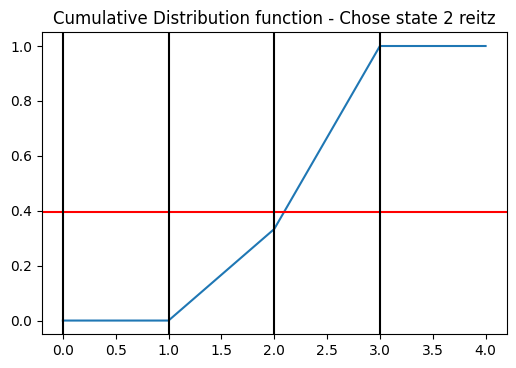


Next state reitz
Next states array: [0, 1, 2, 3, 2]
Next buildings array: ['marston', 'hub', 'reitz', 'lib west', 'reitz']


In [225]:
# demo of a Markov chain predictor
#TODO: make transition matrix look pretty?

#Toy data
bldg_dict = {0: 'marston', 
             1: 'hub',
             2: 'reitz',
             3: 'lib west'}
personHistory = np.array([0,0,0,1,1,2,2,1,2,3,2,3,2,3,1,2,0,1,0])

#Make transition matrix
TransMat = MakeTransitionMatrix(personHistory)
print("TransMat:\n", TransMat)

#Predict future steps based on their most recent history
NumFutureSteps  = 5
MostRecentState = personHistory[-1]
PredictFutureSteps(TransMat, MostRecentState, bldg_dict, NumFutureSteps, PlotCDF=True):